In [235]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

sys.path.append(str(Path.cwd()))

from plotting_constants import coarse_regions, colors
idx = pd.IndexSlice

In [236]:
root = str(Path.cwd().parent.parent.parent / "cluster_data" / "{}_data")

app = "dh"

In [237]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def get_cm(color, factor=2., name="itsacminnit", show=False, asymetric=False):
    """returns colormap between darker and lighter version passed color"""

    if not asymetric:
        colors = [adjust_lightness(color, amount=factor), adjust_lightness(color, amount=1/factor)]
    else:
        colors = [adjust_lightness(color, amount=factor), color]

    cm = LinearSegmentedColormap.from_list(
            name, colors, N=20)

    if show:
        plt.imshow(np.indices((10,10))[1], cmap=cm)
        plt.show()

    return cm

In [239]:

metrics = {
    "elec": "AC_geothermal_generation_share",
    "chp": "uch_geothermal_generation_share",
    "dh": "uch_geothermal_generation_share",
}

def get_data(app):

    header = [4,5,6,7,8]

    df = pd.read_csv(
        Path(root.format(app)) /
        "nodal_geothermal_stats.csv", 
        index_col=[0,1], 
        header=header,
        ).sort_index()


    this = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]

    totals = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]
    totals.index = totals.index.droplevel(1)

    this.columns = this.columns.get_level_values(0)
    this.index = this.index.get_level_values(0)

    # this = df.loc[idx[totals.index[:10], metrics[app]], idx[:,:,"static",:,:]]
    # this.columns = this.columns.get_level_values(0)
    # this.index = this.index.get_level_values(0)

    xp = this.columns.to_numpy().astype(float)
    x = np.linspace(xp[0], xp[-1], 1000)

    data = pd.DataFrame(index=this.index.unique(), columns=[0.1, 0.2, 0.3])

    for bus, thresh in product(data.index, data.columns):

        yp = this.loc[bus].values.astype(float)

        y = np.interp(x, xp, yp)
        data.loc[bus, thresh] = x[len(y[y > thresh])]
    
    return data

get_data(app)

,0.1,0.2,0.3
location,,,
AL1 0,3897.897898,3787.787788,3682.682683
AT1 0,4328.328328,4158.158158,3972.972973
BA1 0,3812.812813,3627.627628,3442.442442
BE1 0,3902.902903,3707.707708,3507.507508
BG1 0,3882.882883,3757.757758,3637.637638
...,...,...,...
RS1 0,3852.852853,3707.707708,3557.557558
SE2 0,5399.399399,5299.299299,5194.194194
SE2 1,4953.953954,4858.858859,4758.758759


C:\Users\lukas\AppData\Local\Temp\ipykernel_14716\3124883061.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\lukas\AppData\Local\Temp\ipykernel_14716\3124883061.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5500"])


[Text(0, -0.5, '1000'), Text(0, 49.5, ''), Text(0, 99.5, '5500')]
100.0
1556.4564564564564


C:\Users\lukas\AppData\Local\Temp\ipykernel_14716\3124883061.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5500"])


[Text(0, -0.5, '1000'), Text(0, 49.5, ''), Text(0, 99.5, '5500')]
1000.0
5444.444444444444


C:\Users\lukas\AppData\Local\Temp\ipykernel_14716\3124883061.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5500"])


[Text(0, -0.5, '1000'), Text(0, 49.5, ''), Text(0, 99.5, '5500')]
1000.0
5354.354354354355


C:\Users\lukas\AppData\Local\Temp\ipykernel_14716\3124883061.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


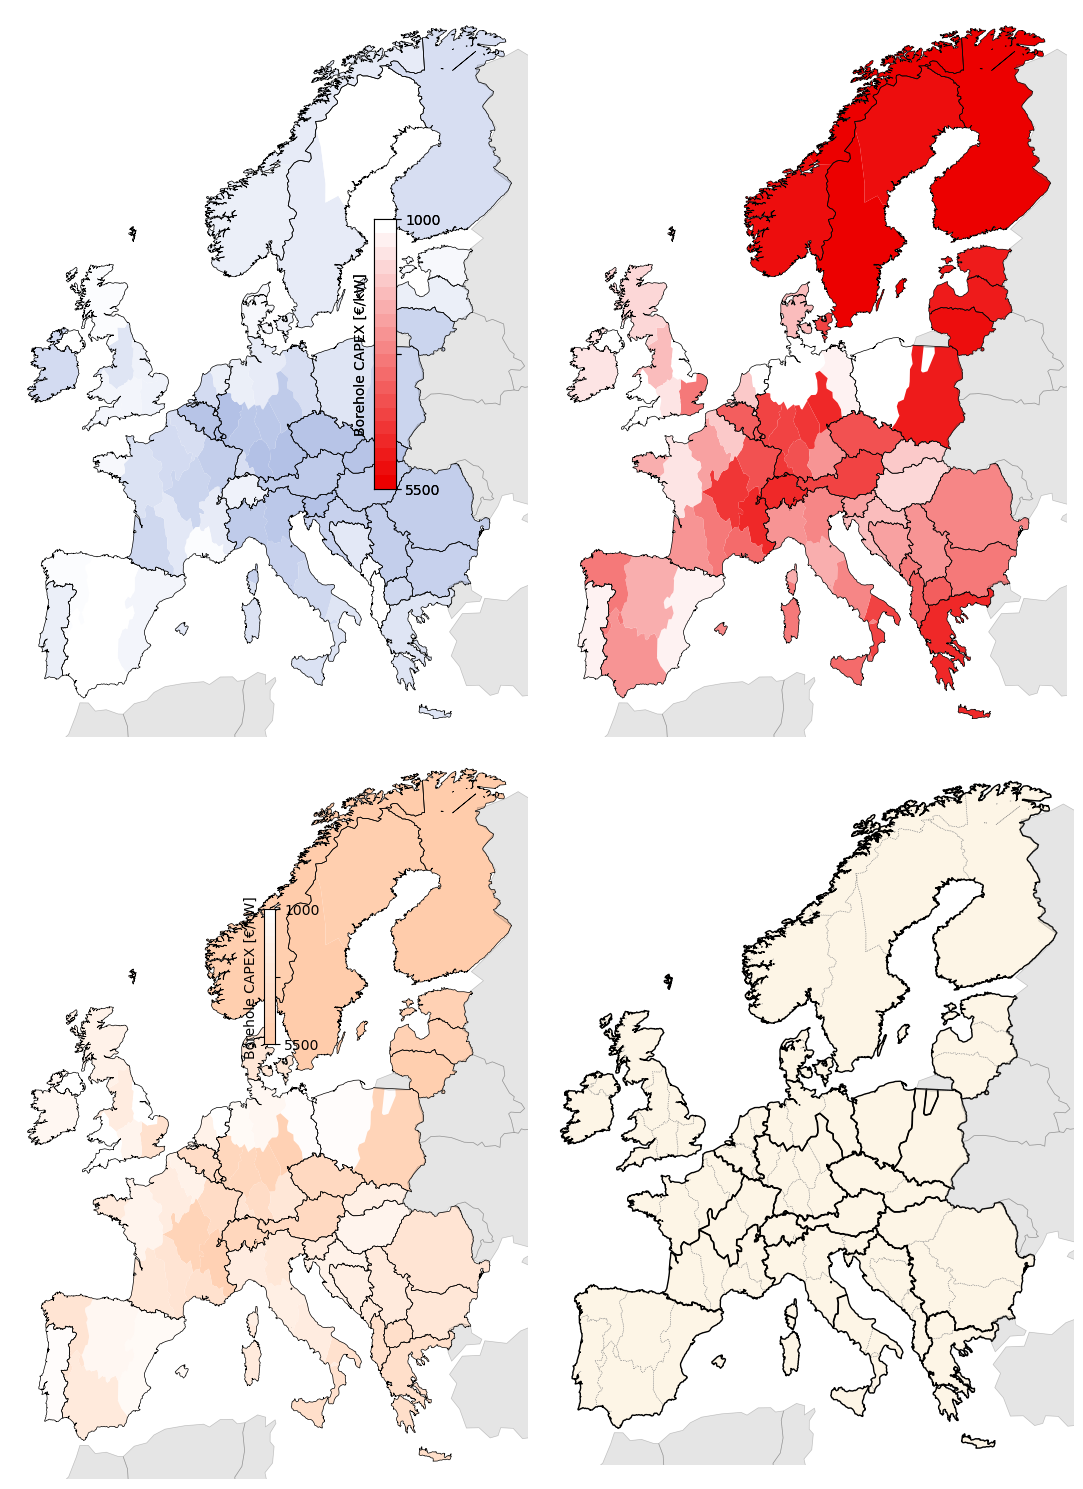

In [246]:
from pyproj import CRS

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap.index = worldmap.name

other_countries = ["Russia", "Ukraine", "Moldova", "Belarus", "Morocco", "Algeria", "Libya", "Egypt", "Tunisia", "Turkey"]

regions = gpd.read_file(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "resources" /
    "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326")

# group regions to countries
regions["country"] = regions["name"].apply(lambda x: x[:2])
countries = regions.dissolve(by="country")

col = 0.1

cmap_kwargs = {
    "elec": dict(factor=1.5, asymetric=False),
    "dh": dict(factor=3, asymetric=True),
    "chp": dict(factor=1.5, asymetric=False),
}

regions = regions.set_index("name")
regions["name"] = regions.index


def plot_regions(col, ax):

    assert col in ["elec", "chp", "dh"]

    color = colors[col]
    regions[col] = get_data(col)[0.1]

    vmin = regions[col].min()
    vmax = regions[col].max()
    cmap = get_cm(color, **cmap_kwargs[app])

    regions.plot(
        ax=ax,
        column=col,
        label=f"10%",
        cmap=cmap,
        )
    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    countries.plot(
        ax=ax,
        color="none",
        edgecolor="black",
        linewidth=0.5,
        )

    cax_lims = {
        "chp": [0.25, 0.30, 0.01, 0.09]
    }

    cax = fig.add_axes(cax_lims.get(col, [0.35, 0.67, 0.02, 0.18]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cax.set_xticks([])

    y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
    y = np.hstack((y, y))

    cax.imshow(y, aspect='auto', cmap=cmap)# , vmin=vmin, vmax=vmax)
    cax.set_ylabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))

    cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))
    if app == "elec":
        cax.set_yticklabels(["250", "", "1500"])
    if app == "dh":
        cax.set_yticklabels(["1000", "", "5500"])
    if app == "chp":
        cax.set_yticklabels(["1000", "", "5350"])
    else:
        print(cax.get_yticklabels())
        print(regions[col].min())
        print(regions[col].max())

    cax.yaxis.set_ticks_position("right")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)

fig, axs = plt.subplots(2, 2, figsize=(11., 15))
# ax.set_facecolor(adjust_lightness("brown", amount=1, asymetric=True))

plot_regions("elec", axs[0,0])
plot_regions("dh", axs[0,1])
plot_regions("chp", axs[1,0])
plot_coarse_regions(axs[-1,-1])

plt.tight_layout()
plt.show()

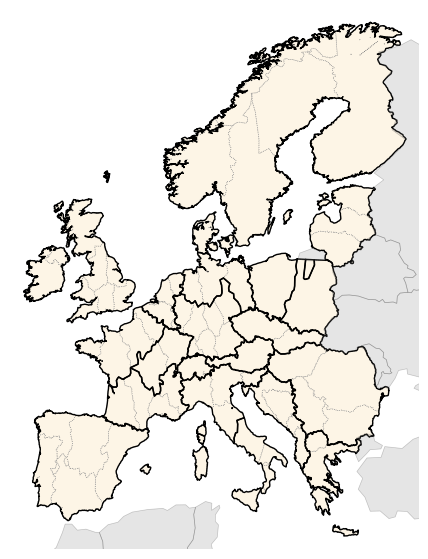

In [48]:
from shapely.ops import unary_union

fig, ax = plt.subplots(1, 1, figsize=(8, 7))

def plot_coarse_regions(ax):
    regions.plot(
        ax=ax,
        color="oldlace",
        edgecolor="grey",
        alpha=1,
        linewidth=0.5,
        label="name",
        linestyle=":"
        )

    for region_name, buses in coarse_regions.items():

        region = regions.loc[buses]
        poly = unary_union(region.geometry).buffer(0.01)
        gpd.GeoSeries([poly]).plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1.)

    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

plot_coarse_regions(ax)

plt.show()


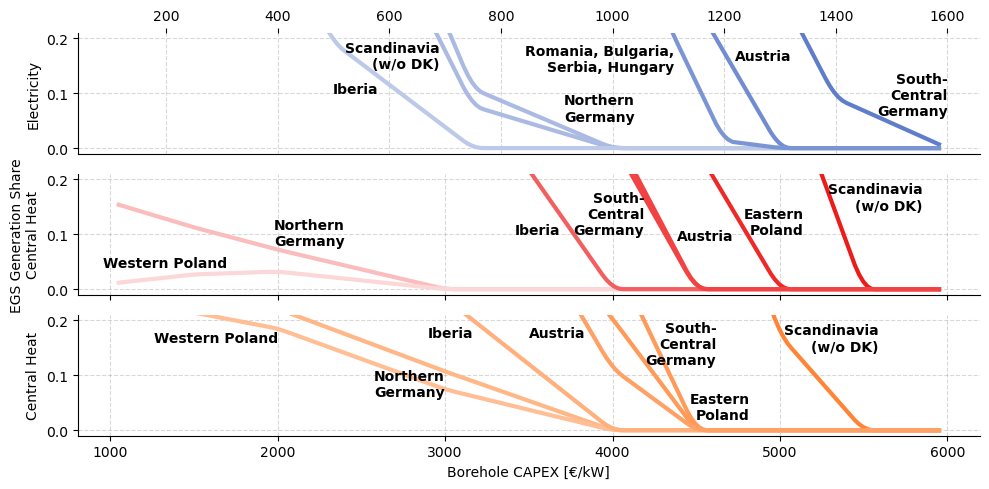

In [233]:
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.pyplot import subplots_adjust

fig, axs = plt.subplots(3, 1, figsize=(10, 5))

show_regions = {
    "elec": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Romania, Bulgaria, Serbia, Hungary",
        "Scandinavia (w/o DK)",
        ],
    "dh": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Scandinavia (w/o DK)",
        "Eastern Poland",
        "Western Poland",
        ],
    "chp": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Scandinavia (w/o DK)",
        "Eastern Poland",
        "Western Poland",
        ]
}

text_pos = {
    "elec": {
        "Iberia": (580,0.1),
        "Southern-Central Germany": (1600,0.06),
        "Austria": (1320,0.16),
        "Romania, Bulgaria, Serbia, Hungary": (1110,0.14),
        "Northern Germany": (1040,0.05),
        "Scandinavia (w/o DK)": (690,0.145),
    },
    "dh": {
        "Western Poland": (1700, 0.04),
        # "Northern Germany": (2000, 0.18),
        "Iberia": (3690, 0.1),
        "Scandinavia (w/o DK)": (5850,0.145),
        "Eastern Poland": (5140, 0.10),
        "Northern Germany": (2400,0.08),
        "Southern-Central Germany": (4190,0.1),
        "Austria": (4720,0.09),
    },
    "chp": {
        "Western Poland": (2000, 0.16),
        "Scandinavia (w/o DK)": (5590,0.145),
        "Eastern Poland": (4820, 0.02),
        "Southern-Central Germany": (4620,0.12),
        "Austria": (3840,0.17),
        "Iberia": (3170,0.17),
        "Northern Germany": (3000, 0.062),
    },
}

renames = {
    "elec": {
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Romania, Bulgaria, Serbia, Hungary": "Romania, Bulgaria,\nSerbia, Hungary",
        "Northern Germany": "Northern\nGermany",
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
    },
    "dh": {
        "Northern Germany": "Northern\nGermany",
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
        "Eastern Poland": "Eastern\nPoland",
    },
    "chp": {
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
        "Eastern Poland": "Eastern\nPoland",
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Northern Germany": "Northern\nGermany",
    },
}


apps = ["elec", "dh", "chp"]
for i, app in enumerate(apps):

    header = [4,5,6,7,8]

    df = pd.read_csv(
        Path(root.format(app)) /
        "nodal_geothermal_stats.csv", 
        index_col=[0,1], 
        header=header,
        ).sort_index()
    color = colors[app]

    totals = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]
    totals.index = totals.index.droplevel(1)

    metric = metrics[app].split("_")[0]

    cmap = get_cm(color, **cmap_kwargs[app])

    for region_name, buses in coarse_regions.items():

        if region_name not in show_regions[app]:
            continue

        total = df.loc[idx[buses, f"{metric}_total_generation"], idx[:,:,"static",:,:]]
        geogen = df.loc[idx[buses, f"{metric}_geothermal_generation"], idx[:,:,"static",:,:]]

        def reduce_ind(df):
            df.columns = df.columns.get_level_values(0)
            df.index = df.index.get_level_values(0)
            return df
        
        total = reduce_ind(total).sum()
        geogen = reduce_ind(geogen).sum()

        x = geogen.index.to_numpy().astype(float)
        y = (geogen / total).values

        thresh = 0.1

        new_x = np.linspace(x[0], x[-1], 200)
        new_y = np.interp(new_x, x, y)

        value = new_x[len(new_y[new_y > thresh])]
        text_value = new_x[len(new_y[new_y > 0.2])]

        series = pd.Series(new_y, index=new_x).rolling(5, center=True).mean()

        # print(app, region_name, text_value)

        if not region_name in text_pos[app]:
            text_y = 0.2 - np.random.rand() * 0.1
        else:
            text_value = text_pos[app][region_name][0]
            text_y = text_pos[app][region_name][1]

        axs[i].plot(series.index, series.values, color=cmap(value/max(x)), linewidth=3, label=region_name)
        # axs[i].text(text_value, text_y, region_name, horizontalalignment="right", fontsize=10, weight='bold')
        axs[i].text(text_value, text_y, renames[app].get(region_name, region_name), horizontalalignment="right", fontsize=10, weight='bold')

        # print(value, region_name, app)

xlimits = {
    "elec": (390, 1610),
    "dh": (2000, 5600),
    "chp": (2000, 5600),
}

for ax in axs:
    ax.set_ylim(-0.01, 0.21)
    ax.grid(linestyle="--", color="grey", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # print(ax.get_yticklabels())

axs[0].set_ylabel("Electricity")
axs[1].set_ylabel("EGS Generation Share\nCentral Heat")
axs[2].set_ylabel("Central Heat")

# axs[0].xaxis.set_label_position("top")
axs[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[1].set_xticklabels([])
axs[-1].set_xlabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))

plt.tight_layout()

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=None)
plt.savefig("generation_shares.pdf")
plt.show()